In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from typing import Any, Tuple

import colorsys
import datetime

from astropy.coordinates import (
    get_body, 
    solar_system_ephemeris,
    EarthLocation, 
    Latitude,
    Longitude, 
    SkyCoord,
)
from astropy.time import Time
from matplotlib.lines import Line2D
from poliastro.bodies import Earth, Venus, Jupiter, Sun
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.twobody import Orbit
from tqdm.auto import tqdm

import astropy.units as u
import matplotlib as mpl
import matplotlib.colors as mc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set default font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Define some auxiliary functions

In [4]:
def adjust_luminosity(
    color: Any, 
    amount: float = 1.2,
) -> Tuple[float, float, float]:
    """
    Adjust the luminosity of the given ``color`` by the ``amount``.
    
    Original source: https://stackoverflow.com/a/49601444/4100721

    Args:
        color: The input color. Can either be a hex string (e.g.,
            `"#FF0000"`), matplotlib color string (e.g., `"C1"` or
            `"green"`), or an RGB tuple in float format (e.g.,
            `(1.0, 0.0, 0.0)`).
        amount: The amount by how much the input color should be
            lightened. For ``amount`` > 1, the color gets brighter; for
            ``amount`` < 1, the color is darkened. By default, colors
            are lightened by 40%.

    Returns:
        An RGB tuple describing the luminosity-adjusted input color.
    """

    # In case `color` is a proper color name, we can try to resolve it into
    # an RGB tuple using the lookup table (of HEX strings) in mc.cnames.
    if isinstance(color, str) and (color in mc.cnames.keys()):
        rgb: Tuple[float, float, float] = mc.to_rgb(mc.cnames[color])

    # Otherwise, we try to convert the color to RGB; this will raise a value
    # error for invalid color formats.
    else:
        rgb = mc.to_rgb(color)

    # Convert color from RBG to HLS representation
    hue, luminosity, saturation = colorsys.rgb_to_hls(*rgb)

    # Multiply `1 - luminosity` by given `amount` and convert back to RGB
    luminosity = max(0.0, min(1.0, amount * luminosity))
    rgb = colorsys.hls_to_rgb(hue, luminosity, saturation)

    return rgb


def disable_ticks(ax: plt.Axes) -> None:
    """
    Disable the ticks and labels on the given matplotlib ``ax``.

    This is similar to calling ``ax.axis('off')``, except that the frame
    around the plot is preserved.

    Args:
        ax: A matplotlib axis.
    """

    ax.tick_params(
        axis='both',
        which='both',
        top=False,
        bottom=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
    )

    
def get_lon_lat(location: SkyCoord) -> Tuple[float, float]:
    """
    Auxiliary function to transform a given `location` and transform
    it into a longitude / latitude that are compatible with matplotlib.
    """

    lon = Longitude(location.ra, wrap_angle=180 * u.deg).to(u.rad).value
    lat = Latitude(location.dec).to(u.rad).value
    return lon, lat


# Define colors for celestial bodies
COLORS = {
    "Sun": "#f89c20",
    "Venus": "#964a8b",
    "Earth": "#5790fc",
    "Jupiter": "#e42536",
}


# Define marker sizes for celestial bodies
MARKER_SIZES = {
    "Sun": 16,
    "Venus": 6,
    "Earth": 6,
    "Jupiter": 10,
}

# Find separation at a given location and epoch

In [5]:
# Set up observation location and time (in UTC)
my_location = EarthLocation(lat=48.53, lon=9.06)
my_time = Time(val='2023-03-02 17:00:00')

# Compute sky positions of Venus and Jupiter
venus_location = get_body('venus', location=my_location, time=my_time)
jupiter_location = get_body('jupiter', location=my_location, time=my_time)

# Compute on-sky separation in degree
print(venus_location.separation(jupiter_location).deg)

0.6908709420973193


# Find the epoch of the minimum separation

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [7]:
# Define a temporal grid around 2023-03-02 with a resolution of 10 minutes
epochs = [
    Time(val='2023-03-02T12:00:00.0') + i * 10 * u.min
    for i in np.linspace(-216, 216, 433)
]

# Compute the separation at each point in time
separations = []
for epoch in epochs:
    v = get_body('venus', location=my_location, time=epoch)
    j = get_body('jupiter', location=my_location, time=epoch)
    separations.append(v.separation(j))

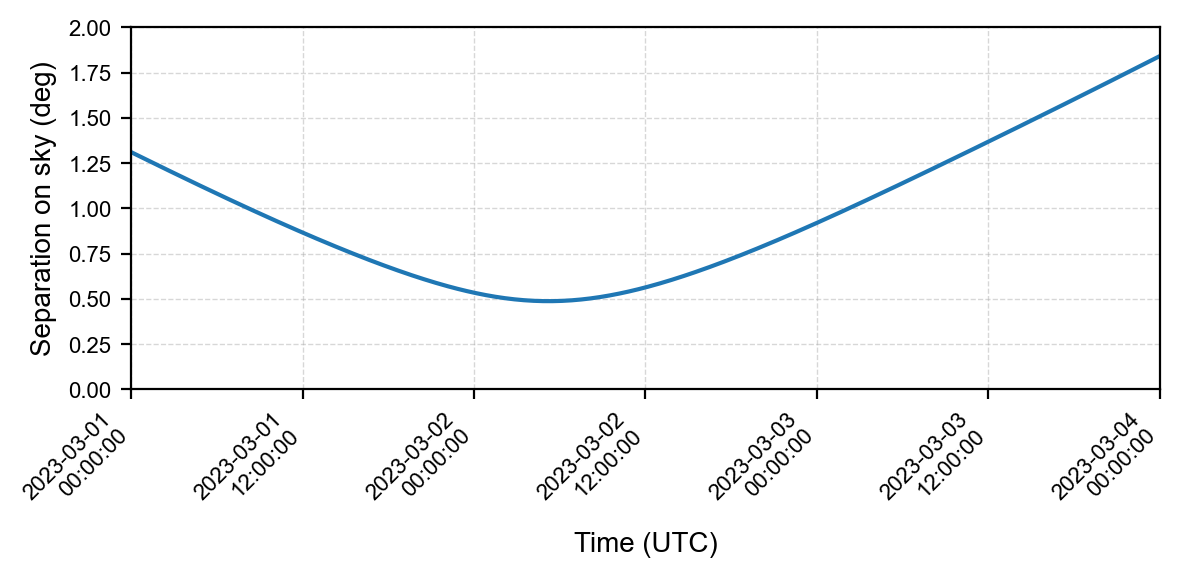

In [8]:
# Create a new figure
fig, ax = plt.subplots(figsize=(6, 3))

# Plot separation in degree over time
ax.plot([_.datetime for _ in epochs], [_.deg for _ in separations])
ax.grid(ls='--', lw=0.5, alpha=0.5)

# Add labels and format the axes nicely
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Separation on sky (deg)")
ax.set_xlim(epochs[0].datetime, epochs[-1].datetime)
ax.set_ylim(0, 2)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M:%S'))
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

# Save the result
plt.savefig(
    '/Users/timothy/Desktop/separation-over-time.png', 
    dpi=300,
    bbox_inches='tight',
    transparent=True,
)
plt.show()

In [9]:
# Set up an interpolator using a 4-th degree spline
interpolator = InterpolatedUnivariateSpline(
    [_.datetime.timestamp() for _ in epochs], 
    [_.deg for _ in separations], 
    k=4
)

# The derivative is a cubic spline, which allows us to find the minimum
# of the separation simply by looking at the `roots`
timestamp = interpolator.derivative().roots()[0]

# Print results
print('Minimum on-sky separation (deg):', interpolator(timestamp))
print('Time of minimum separation in UTC:', datetime.datetime.fromtimestamp(timestamp))

Minimum on-sky separation (deg): 0.48744074356869627
Time of minimum separation in UTC: 2023-03-02 05:13:11.996774


# Create an animation

Note: Creating almost 500 frames can take a while — on my MacBook, it was around 10 minutes.

In [10]:
# Enable higher precision from ephemerides
# See: https://docs.poliastro.space/en/latest/quickstart.html#where-are-the-planets-computing-celestial-ephemerides
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [11]:
# Loop over a temporal grid of 20 days with resolution 1 hour
center = Time(val='2023-03-02 00:00:00', scale="tdb")
for i in tqdm(np.linspace(-240, 240, 480 + 1)):
    
    # Compute the current epoch
    epoch = center + i * datetime.timedelta(hours=1)
    
    # Create a new figure
    fig, axes = plt.subplots(
        nrows=4, 
        figsize=(5, 12),
        height_ratios=(0.8, 6, 1, 4.2),
    )
    axes = axes.flatten()

    # Setup first ax (epoch and legend)
    epoch_ax = axes[0]
    epoch_ax.axis('off')
    
    # Setup second ax (top view)
    top_view_ax = axes[1]
    top_view_ax.set_aspect('equal')
    top_view_ax.set_xlim(-6, 6)
    top_view_ax.set_ylim(-6, 6)
    top_view_ax.set_title('"Top" view')
    disable_ticks(top_view_ax)

    # Setup second ax (side view)
    side_view_ax = axes[2]
    side_view_ax.set_aspect('equal')
    side_view_ax.set_xlim(-6, 6)
    side_view_ax.set_ylim(-1, 1)
    side_view_ax.set_title('"Side" view')
    disable_ticks(side_view_ax)

    # Setup third ax (Mollweide projection view)
    mollweide_ax = axes[3]
    axes[3].remove()
    mollweide_ax = fig.add_subplot(4, 1, 4, projection='aitoff')
    mollweide_ax.grid(ls='--', color='black', alpha=0.2, lw=0.5)
    mollweide_ax.set_title('Sky position (Mollweide projection)', pad=30)

    # Add the current epoch to the first ax
    epoch_ax.text(
        x=0.5, 
        y=1, 
        s=f'Epoch: {epoch} UTC', 
        transform=epoch_ax.transAxes, 
        ha='center', 
        va='top', 
        fontsize=14,
    )
    
    # Create a legend
    handles = [
        Line2D(
            [0], 
            [0], 
            marker='o', 
            lw=0, 
            color=COLORS[body], 
            label=body,
            markersize=MARKER_SIZES[body],
        )
        for body in ('Sun', 'Venus', 'Earth', 'Jupiter')
    ]
    epoch_ax.legend(
        handles=handles, 
        loc='lower center', 
        ncols=4, 
        frameon=False,
    )


    # Keep track of planet positions
    positions = {}

    # Add the Sun to plots
    top_view_ax.plot(
        0, 0, 'o', ms=MARKER_SIZES['Sun'], color=COLORS['Sun'], zorder=99
    )
    side_view_ax.plot(
        0, 0, 'o', ms=MARKER_SIZES['Sun'], color=COLORS['Sun'], zorder=99
    )
    
    # Loop over the planet to compute their positins and plot them
    for i, body in enumerate([Earth, Venus, Jupiter]):

        # Shortcuts for color and marker size
        color = COLORS[body.name]
        light_color = adjust_luminosity(color)
        ms = MARKER_SIZES[body.name]
        
        # Compute the sky positions for Venus and Jupiter and add them
        # to the Mollweide plot
        if body.name != 'Earth':
            location = get_body(body.name, location=my_location, time=epoch)
            mollweide_ax.plot(
                *get_lon_lat(location), 
                'o', 
                ms=ms / 2, 
                color=color, 
                zorder=98-i
            )
        
        # Compute the ephemeris for the current planet
        ephem = Ephem.from_body(
            body, 
            epoch, 
            attractor=body.parent, 
            plane=Planes.EARTH_ECLIPTIC,
        )
        
        # Compute the orbit and convert everything to AU
        orbit = Orbit.from_ephem(Sun, ephem, epoch)
        samples = orbit.sample()
        x = [_._x.to(u.au).value for _ in samples]
        y = [_._y.to(u.au).value for _ in samples]
        z = [_._z.to(u.au).value for _ in samples]

        # Plot top view (orbit and position)
        top_view_ax.plot(x, y, lw=0.5, ls='--', color=light_color)
        top_view_ax.plot(x[0], y[0], 'o', ms=ms, color=color)

        # Plot side view (orbit and position)
        side_view_ax.plot(x, z, lw=0.5, ls='--', color=light_color)
        side_view_ax.plot(x[0], z[0], 'o', ms=ms, color=color)

        # Store the planet position
        positions[body.name] = (x[0], y[0])

    
    # Plot lines connecting Earth with Venus and Jupiter
    for body in ['Venus', 'Jupiter']:
        top_view_ax.plot(
            *zip(positions['Earth'], positions[body]), 
            lw=0.5, 
            c='k', 
            zorder=-99
        )

    # Clean up and save the plot to a PNG
    fig.tight_layout()
    file_name = f'{epoch.datetime.isoformat().replace(":", "-")}.png'
    file_path = f'/Users/timothy/Desktop/frames/{file_name}'
    plt.savefig(
        file_path, 
        dpi=150, 
        bbox_inches='tight',
    )
    plt.close(fig)
    
plt.show()

  0%|          | 0/481 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
%%bash
ffmpeg -framerate 24 -pattern_type glob -i '/Users/timothy/Desktop/frames/*.png' -c:v libx264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" /Users/timothy/Desktop/frames/animation.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2-with-options_1 --enable-shared --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libaom --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-libsnappy --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-demuxer=dash --enable-opencl --enable-audiotoolbox --enable-videotoolbox --disable-htmlpages --enable-libvidstab
  libavutil      57. 28.100 / 57. 28.100
  libavcodec     59. 37.100 / 59. 37.100
  libavformat    59. 27.100 / 59. 27.100
  libavdevice    59.  7.100 / 59.  7.100
  libavfilter     8. 44.100 /  8. 44.100
  libswscale      6.  7.100 /  6.  7.100
  libswresample   4.  7.100 /  4.  7.100
  libpostproc    56.  6.100 / 56.  6.100
Input #0, image2, from '